# Autoencoders
This exercise is a variation of [Tensorflow Intro to Autoencoders tutorial](https://www.tensorflow.org/tutorials/generative/autoencoder). An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.


Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

<a target="_blank" href="https://colab.research.google.com/github/PrzemekSekula/DeepLearningClasses1/blob/master/Autoencoders/Autoencoders_done.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Helper functions

In [2]:
def plot_mnist(images1, labels1 = None, images2 = None, labels2 = None,n=10):
    """
    Plots n images in a row with their labels. Can plot two rows of images.
    Args:
        images1 (np.array): array of images
        labels1 (list, optional): labels for images1. Defaults to None.
        images2 (np.array, optional): array of images in the second row. Defaults to None.
        labels2 (list, optional): labels for images2. Defaults to None.
        n (int, optional): number of images to plot. Defaults to 10.
    """
    plt.figure(figsize=(2*n, 4))
    if images2 is None:
        nr_rows = 1
    else:
        nr_rows = 2
    for i in range(n):
    # display original
        ax = plt.subplot(nr_rows, n, i + 1)
        img = images1[i]
        if len(img.shape) > 2:
            img = tf.squeeze(img)
        plt.imshow(img)
        if labels1 is not None:
            plt.title(labels1[i])
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if images2 is not None:
    # display reconstruction
            ax = plt.subplot(nr_rows, n, i + 1 + n)
            img = images2[i]
            if len(img.shape) > 2:
                img = tf.squeeze(img)
            plt.imshow(img)
            if labels2 is not None:
                plt.title(labels2[i])
            # plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

def plot_history(history):
    """
    Plots the loss and accuracy of the model.
    Args:
        history (keras.callbacks.History): Model.fit output
    """
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [3]:
import os
import cv2
import numpy as np

In [4]:
X_train = []
for img_dir in os.listdir('data/train/'):
    for filepath in os.listdir('data/train/{0}'.format(img_dir)):
        X_train.append(cv2.cvtColor(cv2.imread('data/train/{0}/{1}'.format(img_dir, filepath),1),cv2.COLOR_BGR2RGB))
X_train = np.asarray(X_train)

In [5]:
os.listdir('data/train/')

['baseball',
 'basketball',
 'football',
 'rugby',
 'ski jumping',
 'swimming',
 'tennis',
 'volleyball']

In [6]:
X_test = []
for img_dir in os.listdir('data/test/'):
    for filepath in os.listdir('data/test/{0}'.format(img_dir)):
        X_test.append(cv2.cvtColor(cv2.imread('data/test/{0}/{1}'.format(img_dir, filepath),1),cv2.COLOR_BGR2RGB))
X_test = np.asarray(X_test)

In [7]:
X_test.shape

(40, 224, 224, 3)

In [8]:
X_train.shape

(1225, 224, 224, 3)

In [9]:
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
del X_test, X_train

In [10]:
# x_train = x_train[:400,:,:,:]

In [11]:
# x_train = x_train[..., tf.newaxis]
# x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(1225, 224, 224, 3)


#### Adding noise to images
Let's add Gausian nosie to our datasets 

In [12]:
noise_factor = 0.15
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

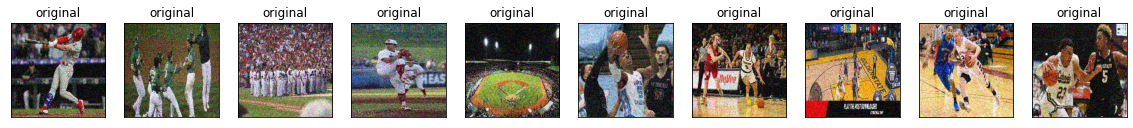

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#### Task 4 - Create an autoencoder for denoisification
Create `Denoise` class that inherits from `tensorflow.keras.models.Model`. This class should have the following layers:
- Encoder:
    - `Input` layer with shape = (28, 28, 1)
    - `Conv2D` layer with `16` `3x3` filters, `relu` activation function, `same` padding and `stide=2`
    - `Conv2D` layer with `8` `3x3` filters, `relu` activation function, `same` padding and `stide=2`
- Decoder:
    - `Conv2DTranspose` layer with `8` `3x3` filters, `relu` activation function, `same` padding and `stide=2`
    - `Conv2DTranspose` layer with `16` `3x3` filters, `relu` activation function, `same` padding and `stide=2`
    - `Conv2D` layer with `1` `3x3` filter, `sigmoid` activation function, and `same` padding

*Note 1: Remember to implement the `call` method.*

*Note 2: Try to understand the size of inputs and outputs for each layer. You may be asked about this.*

*Note 3: Make sure, that you understand deconvolution layers (`Conv2DTranspose`). You may learn about it [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose).*




In [14]:
class Denoise(Model):
    def __init__(self):
        super().__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(224, 224, 3)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/8
39/39 [==============================] - 41s 998ms/step - loss: 0.0793 - val_loss: 0.0692
Epoch 2/8
39/39 [==============================] - 39s 1s/step - loss: 0.0451 - val_loss: 0.0282
Epoch 3/8
39/39 [==============================] - 39s 1s/step - loss: 0.0249 - val_loss: 0.0229
Epoch 4/8
39/39 [==============================] - 40s 1s/step - loss: 0.0222 - val_loss: 0.0217
Epoch 5/8
39/39 [==============================] - 39s 1s/step - loss: 0.0211 - val_loss: 0.0204
Epoch 6/8
39/39 [==============================] - 39s 1s/step - loss: 0.0203 - val_loss: 0.0200
Epoch 7/8
39/39 [==============================] - 39s 1s/step - loss: 0.0197 - val_loss: 0.0190
Epoch 8/8
39/39 [==============================] - 39s 1s/step - loss: 0.0184 - val_loss: 0.0167


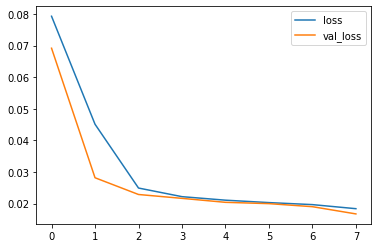

In [15]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=8,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
plot_history(history)

In [16]:
# history = autoencoder.fit(x_train_noisy, x_train,
#                 epochs=10,
#                 shuffle=True,
#                 validation_data=(x_test_noisy, x_test))
# plot_history(history)

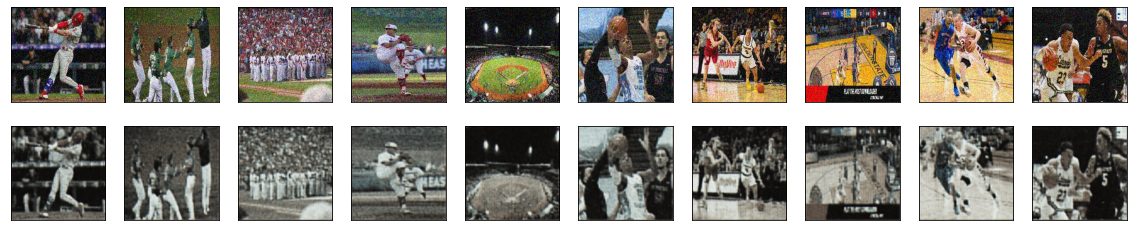

In [17]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
plot_mnist(x_test_noisy, images2 = decoded_imgs)

In [82]:
autoencoder.encoder.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 56, 56, 8)         2312      
                                                                 
Total params: 3,208
Trainable params: 3,208
Non-trainable params: 0
_________________________________________________________________


In [83]:
autoencoder.decoder.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_8 (Conv2DT  (None, 112, 112, 8)      584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 224, 224, 32)     2336      
 ranspose)                                                       
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 3)       867       
                                                                 
Total params: 3,787
Trainable params: 3,787
Non-trainable params: 0
_________________________________________________________________


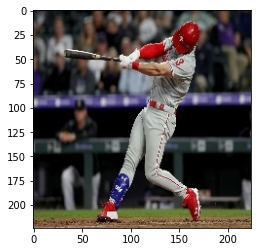

In [148]:
plt.imshow(x_test[0])

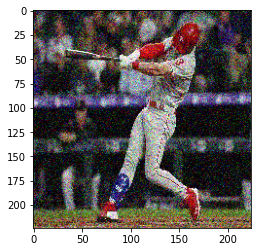

In [143]:
plt.imshow(tf.squeeze(x_test_noisy[0]))

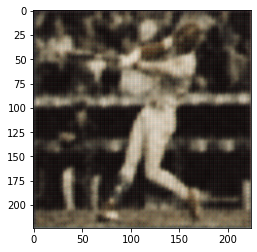

In [144]:
plt.imshow(decoded_imgs[0, ...])

In [149]:
decoded_imgs.shape

(40, 224, 224, 3)

In [150]:
x_train[0].min(), x_train[0].max()

(0.0, 1.0)

In [151]:
x_train_noisy[0].numpy().min(), x_train_noisy[0].numpy().max()

(0.0, 1.0)

In [152]:
i = decoded_imgs[0]
i.shape

(224, 224, 3)

In [153]:
tmp = i[:, :, 0] - i[:, :, 2]

In [154]:
tmp.max()

0.2832675

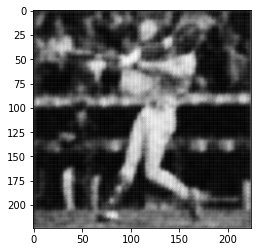

In [155]:
plt.imshow(i[:, :, 1])

In [156]:
x_train.shape

(400, 224, 224, 3)

In [157]:
x_test.shape

(40, 224, 224, 3)